In [1]:
import torch
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

In [ ]:
import random

random_seed = 42

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [2]:
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html

n_dim = 2
x_train, y_train = make_blobs(n_samples=80, n_features=n_dim,
                              centers=[[0,0],[1,1],[1,0],[0,1]],
                              shuffle=True, cluster_std=0.15)
x_test, y_test = make_blobs(n_samples=20, n_features=n_dim,
                            centers=[[0,0],[1,1],[1,0],[0,1]],
                            shuffle=True, cluster_std=0.15)

In [3]:
# 15번째 sample까지만 print

for i, x in enumerate(x_train):
    print(x, y_train[i])
    if i == 15 : break

[1.03770179 1.16365902] 1
[1.14308816 1.15833213] 1
[-0.22351031  0.12671775] 0
[0.84521717 0.10888187] 2
[ 0.03327563 -0.06517709] 0
[0.00587267 0.14956022] 0
[1.01502745 0.91195094] 1
[1.1630388  0.86391147] 1
[0.06418298 0.1256151 ] 0
[-0.15288564  0.15796731] 0
[0.07289311 0.86368275] 3
[ 1.12429231 -0.20544425] 2
[-0.07914007  0.05161167] 0
[-0.12203986  0.25128575] 0
[ 0.97461459 -0.32317562] 2
[1.0500158  0.08859226] 2


In [4]:
# label 0, 1 -> 0으로 매핑
# label 2, 3 -> 1로 매핑

def label_map(y_, from_, to_):
    y = np.copy(y_)
    for f in from_:
        y[y_ == f] = to_
    return y

y_train = label_map(y_train, [0, 1], 0)
y_train = label_map(y_train, [2, 3], 1)
y_test = label_map(y_test, [0, 1], 0)
y_test = label_map(y_test, [2, 3], 1)

In [22]:
y_train.max(), y_train.min()

(tensor(1.), tensor(0.))

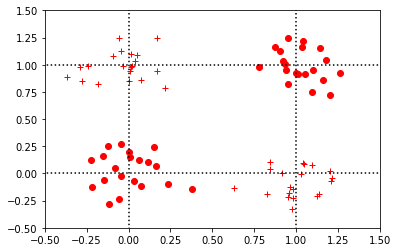

In [5]:
def vis_data(x,y = None, c = 'r'):
    if y is None:
        y = [None] * len(x)
    for x_, y_ in zip(x,y):
        if y_ is None:
            plt.plot(x_[0], x_[1], '*',markerfacecolor='none', markeredgecolor=c)
        else:
            plt.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')

plt.figure()
vis_data(x_train, y_train, c='r')
plt.plot([-1, 2], [0,0], linestyle = ":", color = 'k')
plt.plot([-1, 2], [1,1], linestyle = ":", color = 'k')
plt.plot([0, 0], [-1, 2], linestyle = ":", color = 'k')
plt.plot([1, 1], [-1,2], linestyle = ":", color = 'k')

plt.xlim([-0.5, 1.5])
plt.ylim([-0.5, 1.5])
plt.show()

In [6]:
x_train = torch.FloatTensor(x_train)
print(x_train.shape)
print(y_train.shape)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

torch.Size([80, 2])
(80,)


In [7]:
class NeuralNet(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(NeuralNet, self).__init__() # NeuralNet(자식 클래스)이 상속받는 torch.nn.Module(부모 클래스)을 우리의 NeuralNet에 불러오겠다는 의미
            self.input_size = input_size      # init 시 self.를 앞에 붙여줘야 함.
            self.hidden_size  = hidden_size
            
            self.linear_1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            ### 수정 ###
            # self.linear_2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
            ############
            self.linear_last = torch.nn.Linear(self.hidden_size, 1)   # Binary Classification(classes: 2)
            self.sigmoid = torch.nn.Sigmoid()                         # 0~1
            
        def forward(self, input_tensor):
            linear1 = self.linear_1(input_tensor)
            relu1 = self.relu(linear1)
            linear2 = self.linear_last(relu1)
            output = self.sigmoid(linear2)
            return output

In [8]:
learning_rate = 0.01
epochs = 2000
hidden_size = 5

### Model Initialize ###
model = NeuralNet(2, hidden_size)   # (Input size, Hidden size)
criterion = torch.nn.BCELoss()  # Binary Cross-Entropy  
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) # Stochastic Gradient Descent

In [9]:
print(model)

NeuralNet(
  (linear_1): Linear(in_features=2, out_features=5, bias=True)
  (relu): ReLU()
  (linear_last): Linear(in_features=5, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [10]:
model.eval() # Gradient Backpropagation(역전파)를 중지 -> Validation 및 Test 시에 사용
test_loss_before = criterion(model(x_test).squeeze(), y_test)
print('Before Training, test loss is {}'.format(test_loss_before.item()))

Before Training, test loss is 0.7699571847915649


In [11]:
# 한 번 학습

model.train()   # Gradient Update 실행.
optimizer.zero_grad()   # Gradient를 0으로 초기화
train_output = model(x_train)
train_loss = criterion(train_output.squeeze(), y_train)
train_loss.backward() # Backpropagation
optimizer.step()

In [12]:
train_losses = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_output = model(x_train)
    train_loss = criterion(train_output.squeeze(), y_train)
    if epoch % 100 == 0:
        print('Train loss at {} is {}'.format(epoch, train_loss.item()))
        train_losses.append(train_loss.item())
        torch.save(model.state_dict(), './model_epoch{}.pt'.format(epoch))
    train_loss.backward()
    optimizer.step()

Train loss at 0 is 0.7776657342910767
Train loss at 100 is 0.7199282050132751
Train loss at 200 is 0.7004308104515076
Train loss at 300 is 0.6923937797546387
Train loss at 400 is 0.6883708238601685
Train loss at 500 is 0.6857278943061829
Train loss at 600 is 0.6836658716201782
Train loss at 700 is 0.681761622428894
Train loss at 800 is 0.6797232627868652
Train loss at 900 is 0.6775308847427368
Train loss at 1000 is 0.6751306056976318
Train loss at 1100 is 0.6724316477775574
Train loss at 1200 is 0.6695770025253296
Train loss at 1300 is 0.6667602062225342
Train loss at 1400 is 0.663888156414032
Train loss at 1500 is 0.6610198616981506
Train loss at 1600 is 0.6580163240432739
Train loss at 1700 is 0.654836893081665
Train loss at 1800 is 0.6514850854873657
Train loss at 1900 is 0.647963285446167


In [13]:
# # train loss 그래프

# plt.plot(train_losses)
# plt.title('Train Loss')
# plt.show()

In [14]:
model.eval()
test_loss = criterion(model(x_test).squeeze(), y_test)
print('After Training, test loss is {}'.format(test_loss.item()))

After Training, test loss is 0.6361403465270996


In [15]:
torch.save(model.state_dict(), './model.pt')
print('state_dict format of the model: {}'.format(model.state_dict()))

state_dict format of the model: OrderedDict([('linear_1.weight', tensor([[-0.0143,  0.5913],
        [-0.4718, -0.3628],
        [-0.1087, -0.1443],
        [-0.6567, -0.5941],
        [-0.2300, -0.0437]])), ('linear_1.bias', tensor([ 0.5803, -0.1173, -0.2474,  0.5609,  0.5777])), ('linear_last.weight', tensor([[-0.1303,  0.1695, -0.4129, -0.9190,  0.0725]])), ('linear_last.bias', tensor([0.1833]))])


In [16]:
# 새로운 모델에 학습된 가중치 로드

new_model = NeuralNet(2, hidden_size)
new_model.load_state_dict(torch.load('./model.pt'))
new_model.eval()
print('벡터 [0, 1]이 레이블 1을 가질 확률은 {}'.format\
      (new_model(torch.FloatTensor([0,1])).item()))

벡터 [0, 1]이 레이블 1을 가질 확률은 0.5173606276512146


In [17]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round((y_pred)).squeeze()

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [18]:
new_model.eval()
print(torch.round(new_model(x_test)).squeeze())
print(y_test)
print(binary_acc(new_model(x_test), y_test))

tensor([1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1.,
        1., 1.], grad_fn=<SqueezeBackward0>)
tensor([1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
        1., 1.])
tensor(65.)


In [19]:
# Train epoch마다 성능 평가

for i in range(0,2000,100):
    new_model = NeuralNet(2, hidden_size)
    new_model.load_state_dict(torch.load('./model_epoch{}.pt'.format(i)))
    new_model.eval()
    print("======epoch : {} =======".format(i))
    print(binary_acc(new_model(x_test), y_test))

======epoch : 0 =======
tensor(50.)
======epoch : 100 =======
tensor(50.)
======epoch : 200 =======
tensor(50.)
======epoch : 300 =======
tensor(50.)
======epoch : 400 =======
tensor(50.)
======epoch : 500 =======
tensor(65.)
======epoch : 600 =======
tensor(75.)
======epoch : 700 =======
tensor(75.)
======epoch : 800 =======
tensor(75.)
======epoch : 900 =======
tensor(70.)
======epoch : 1000 =======
tensor(55.)
======epoch : 1100 =======
tensor(65.)
======epoch : 1200 =======
tensor(70.)
======epoch : 1300 =======
tensor(70.)
======epoch : 1400 =======
tensor(70.)
======epoch : 1500 =======
tensor(65.)
======epoch : 1600 =======
tensor(65.)
======epoch : 1700 =======
tensor(65.)
======epoch : 1800 =======
tensor(65.)
======epoch : 1900 =======
tensor(65.)
